# New York City taxi fair

## 1. Library とデータの読み込み

In [1]:
import os
import gc
import sys # Pythonのインタプリタや実行環境に関する情報を扱うためのライブラリ
import pandas as pd # データを扱うための標準的なライブラリ
import numpy as np # 多次元配列を扱う数値演算ライブラリ
import scipy as sp # 高度な科学計算を行うためのライブラリ
import sklearn # 機械学習のライブラリ

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor as RFR
import lightgbm as lgbm  # conda install -c conda-forge lightgbm
import xgboost as xgb    # conda install -c anaconda py-xgboost
from catboost import CatBoost # conda install -c conda-forge catboost
from catboost import Pool

import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()

import matplotlib.pyplot as plt # グラフを描画するライブラリ
import seaborn as sns
%matplotlib inline 
plt.style.use('seaborn-whitegrid')
# jupyter内に描画

# メモリ不足対応
# https://github.com/jupyterhub/jupyterhub/issues/713
#import pyspark
#import random
#memory = '8g'
#pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
#os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args
#sc = pyspark.SparkContext(appName="Pi")

In [2]:
df = pd.read_csv("./data/NYC_taxi_small.csv")
df.head()

key  fare_amount          pickup_datetime  \
0    2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1    2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2   2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3    2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4  2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.844311        40.721319         -73.841610         40.712278   
1        -74.016048        40.711303         -73.979268         40.782004   
2        -73.982738        40.761270         -73.991242         40.750562   
3        -73.987130        40.733143         -73.991567         40.758092   
4        -73.968095        40.768008         -73.956655         40.783762   

   passenger_count  
0                1  
1                1  
2                2  
3                1  
4                1

In [3]:
df.shape

(500000, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                500000 non-null  object 
 1   fare_amount        500000 non-null  float64
 2   pickup_datetime    500000 non-null  object 
 3   pickup_longitude   500000 non-null  float64
 4   pickup_latitude    500000 non-null  float64
 5   dropoff_longitude  499995 non-null  float64
 6   dropoff_latitude   499995 non-null  float64
 7   passenger_count    500000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 30.5+ MB


In [5]:
# 欠損値のカウント
df.isnull().apply(lambda col: col.value_counts(), axis=0).fillna(0).astype(np.int)

key  fare_amount  pickup_datetime  pickup_longitude  \
False  500000       500000           500000            500000   
True        0            0                0                 0   

       pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
False           500000             499995            499995           500000  
True                 0                  5                 5                0

In [6]:
# 欠損値のカウント
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64

In [7]:
# 欠損値を含む行を削除
df = df.dropna()
df.shape

(499995, 8)

In [8]:
# 欠損値のカウント
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

## 2. 乗車・下車位置の地図上へのプロット

### Location data

#### https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration

In [9]:
# read data in pandas dataframe
df_test =  pd.read_csv('./data/test.csv')

In [10]:
# minimum and maximum longitude test set
min(df_test.pickup_longitude.min(), df_test.dropoff_longitude.min()), \
max(df_test.pickup_longitude.max(), df_test.dropoff_longitude.max())

(-74.263242, -72.986532)

In [11]:
# minimum and maximum latitude test
min(df_test.pickup_latitude.min(), df_test.dropoff_latitude.min()), \
max(df_test.pickup_latitude.max(), df_test.dropoff_latitude.max())

(40.568973, 41.709555)

In [12]:
def select_within_boundingbox(df, BB):
    return (df.pickup_longitude >= BB[0]) & (df.pickup_longitude <= BB[1]) & \
           (df.pickup_latitude >= BB[2]) & (df.pickup_latitude <= BB[3]) & \
           (df.dropoff_longitude >= BB[0]) & (df.dropoff_longitude <= BB[1]) & \
           (df.dropoff_latitude >= BB[2]) & (df.dropoff_latitude <= BB[3])
            
# load image of NYC map
BB = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('https://aiblog.nl/download/nyc_-74.5_-72.8_40.5_41.8.png')

# load extra image to zoom in on NYC
BB_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('https://aiblog.nl/download/nyc_-74.3_-73.7_40.5_40.9.png')

In [13]:
print('Old size: %d' % len(df))
df = df[select_within_boundingbox(df, BB)]
print('New size: %d' % len(df))

Old size: 499995
New size: 489484


In [14]:
# this function will be used more often to plot data on the NYC map
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

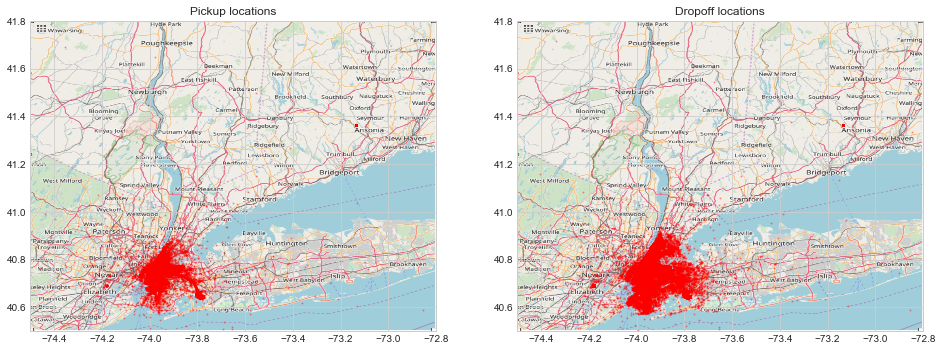

In [15]:
# plot data on map
plot_on_map(df, BB, nyc_map, s=1, alpha=0.3)

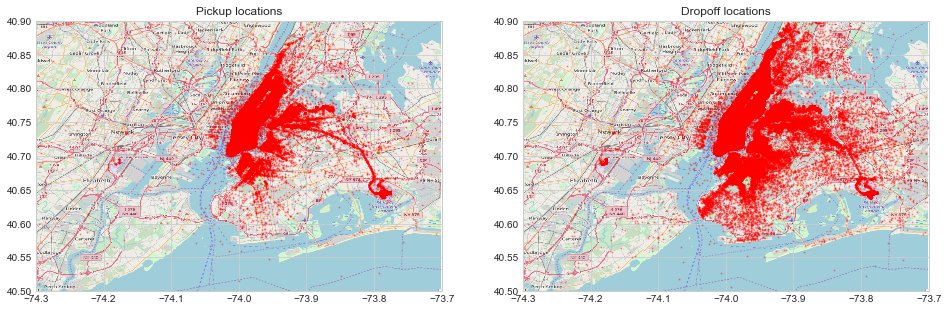

In [16]:
# plot data on map zoomed in
plot_on_map(df, BB_zoom, nyc_map_zoom, s=1, alpha=0.3)

In [17]:
def plot_hires(df, BB, figsize=(12, 12), ax=None, c=('r', 'b')):
    if ax == None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    idx = select_within_boundingbox(df, BB)
    ax.scatter(df[idx].pickup_longitude, df[idx].pickup_latitude, c=c[0], s=0.01, alpha=0.5)
    ax.scatter(df[idx].dropoff_longitude, df[idx].dropoff_latitude, c=c[1], s=0.01, alpha=0.5)

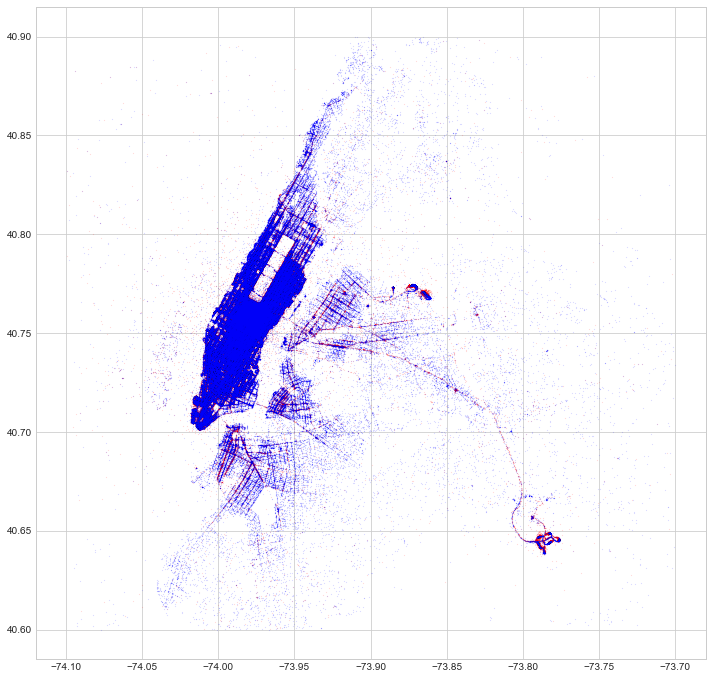

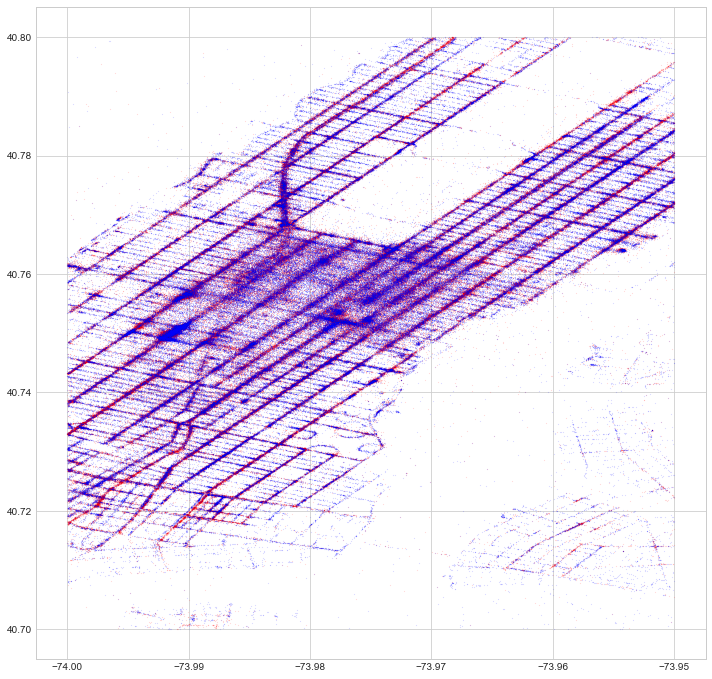

In [18]:
plot_hires(df, (-74.1, -73.7, 40.6, 40.9))
plot_hires(df, (-74, -73.95, 40.7, 40.8))

### Removing datapoints in water

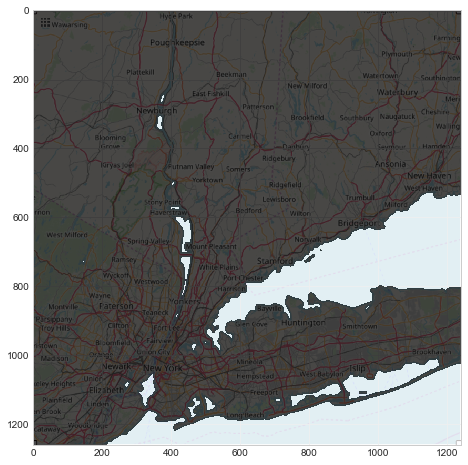

In [19]:
# read nyc mask and turn into boolean map with
# land = True, water = False
nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9

plt.figure(figsize=(8,8))
plt.imshow(nyc_map, zorder=0)
plt.imshow(nyc_mask, zorder=1, alpha=0.7); # note: True is show in black, False in white.

In [20]:
# translate longitude/latitude coordinate into image xy coordinate
def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

In [21]:
pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)
dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                  nyc_mask.shape[1], nyc_mask.shape[0], BB)

In [22]:
idx = (nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x])
print("Number of trips in water: {}".format(np.sum(~idx)))

Number of trips in water: 85


In [23]:
def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('https://aiblog.nl/download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [24]:
print('Old size: %d' % len(df))
df = remove_datapoints_from_water(df)
print('New size: %d' % len(df))

Old size: 489484
New size: 489399


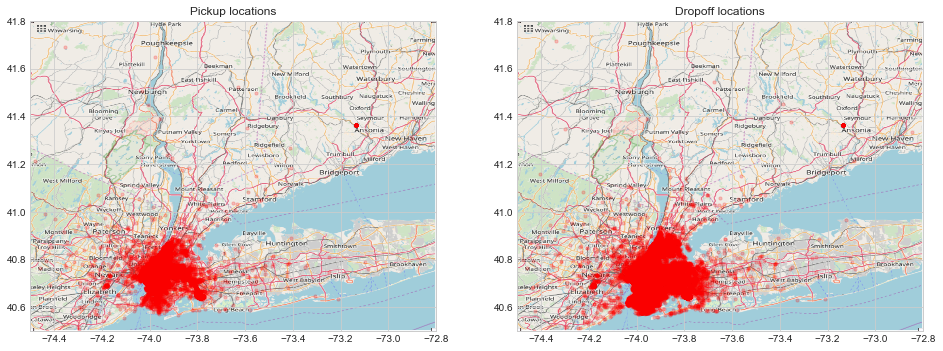

In [25]:
# plot training data
plot_on_map(df, BB, nyc_map)

In [26]:
df.shape

(489399, 8)

In [27]:
# Cleansed data の保存
df.to_csv("./data/df_cleansed.csv",index=False)